In [1]:
import numpy as np
import torch
import pyepo

# random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
grid = (5,5) # grid size
num_data = 1000 # number of training data
num_feat = 5 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.shortestpath.genData(num_data+100+1000, num_feat, grid, deg, e, seed=42)

In [3]:
from pyepo.model.grb import shortestPathModel
# set solver
optmodel = shortestPathModel(grid)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
for i, e in enumerate(optmodel.arcs):
    if sol[i] > 1e-3:
        print(e)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 3.6258033206091707
(0, 1)
(1, 6)
(6, 7)
(7, 12)
(12, 17)
(17, 18)
(18, 19)
(19, 24)


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 942.51it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 854.76it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 926.69it/s]


In [6]:
# get training and test data set without costs
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, costs=dataset_train_cost.costs)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 427.64it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, (grid[0]-1)*grid[1]+(grid[1]-1)*grid[0])

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt
def plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw grad plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(grad_log, color="g", alpha=0.5, lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.gca().yaxis.get_offset_text().set_size(24)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Abs Grad", fontsize=36)
    plt.title("Absolute Gradient Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-0.5, num_epochs+0.5)
    plt.ylim(0, 0.5)
    plt.xticks(range(0, num_epochs+1, 2), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
num_epochs = 10
log_step = 1

In [11]:
import copy
import time
from tqdm import tqdm
import torch.nn.functional as F

from earlystop import earlyStopper
from clipgrad import clipGrad

def pipeline(reg, forward_func, loss_func, lr, num_epochs, 
             log_step, loader_train, loader_val, loader_test, grad_clip=False, seed=42):
    # set random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    stop = False
    # init best model
    best_model_state = copy.deepcopy(reg.state_dict())
    best_val_regret = float("inf")
    # init log
    loss_log = []
    grad_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".format(epoch, regret_trn*100, regret_val*100))
            # update best model
            if regret_val < best_val_regret:
                best_val_regret = regret_val
                best_model_state = copy.deepcopy(reg.state_dict())
            # early stop
            if stopper.stop(regret_val):
                print()
                stop = True
                print("Early Stop!")
                break
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass
            loss = forward_func(data, reg, loss_func, grad_log)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # clip
            if grad_clip:
                clipGrad(reg, threshold=1e-6)
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # no early stop
    if not stop:
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
        regret_log_val.append(regret_val)
        tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".format(epoch, regret_trn*100, regret_val*100))
        # update best model
        if regret_val < best_val_regret:
            best_val_regret = regret_val
            best_model_state = copy.deepcopy(reg.state_dict())
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    # restore best model
    reg.load_state_dict(best_model_state)
    print()
    print("Evaluation:")
    tick = time.time()
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    tock = time.time()
    elapsed = tock - tick
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Test Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, grad_log, regret_log_trn, regret_log_val

def forwardCAVE(data, reg, loss_func, grad_log, reg_lambda=1e0):
    # unzip data
    x, c, _, t_ctr = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, t_ctr) + reg_lambda * F.mse_loss(cp, c)
    return loss

### Exact Method with NNLS

In [12]:
# init model
reg = LinearRegression()

In [13]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="nnls", processes=1)

(CVXPY) Dec 06 07:31:30 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')
Num of cores: 1


In [14]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/10 [00:01<?, ?it/s]

Epoch   0, Train Regret:  61.9579%, Val Regret:  66.5088%


Epoch    0, Loss:  -0.8475:  10%|█████▌                                                 | 1/10 [00:05<00:35,  3.90s/it]

Epoch   1, Train Regret:  10.4251%, Val Regret:   9.8968%


Epoch    1, Loss:  -0.7911:  20%|███████████                                            | 2/10 [00:08<00:26,  3.27s/it]

Epoch   2, Train Regret:   8.5180%, Val Regret:   8.0653%


Epoch    2, Loss:  -0.9094:  30%|████████████████▌                                      | 3/10 [00:11<00:21,  3.09s/it]

Epoch   3, Train Regret:   8.4888%, Val Regret:   8.1543%


Epoch    3, Loss:  -0.8873:  40%|██████████████████████                                 | 4/10 [00:14<00:18,  3.01s/it]

Epoch   4, Train Regret:   7.9428%, Val Regret:   7.5885%


Epoch    4, Loss:  -0.9413:  50%|███████████████████████████▌                           | 5/10 [00:16<00:14,  2.98s/it]

Epoch   5, Train Regret:   8.6418%, Val Regret:   9.0542%


Epoch    5, Loss:  -0.7677:  60%|█████████████████████████████████                      | 6/10 [00:19<00:11,  2.97s/it]

Epoch   6, Train Regret:   9.0088%, Val Regret:  10.1560%


Epoch    6, Loss:  -0.8880:  70%|██████████████████████████████████████▌                | 7/10 [00:22<00:09,  3.28s/it]


Epoch   7, Train Regret:   8.3728%, Val Regret:   8.4884%

Early Stop!
Training Elapsed Time: 3.50 Sec

Evaluation:
Test Regret: 8.5844%
Test Elapsed Time: 1.57 Sec


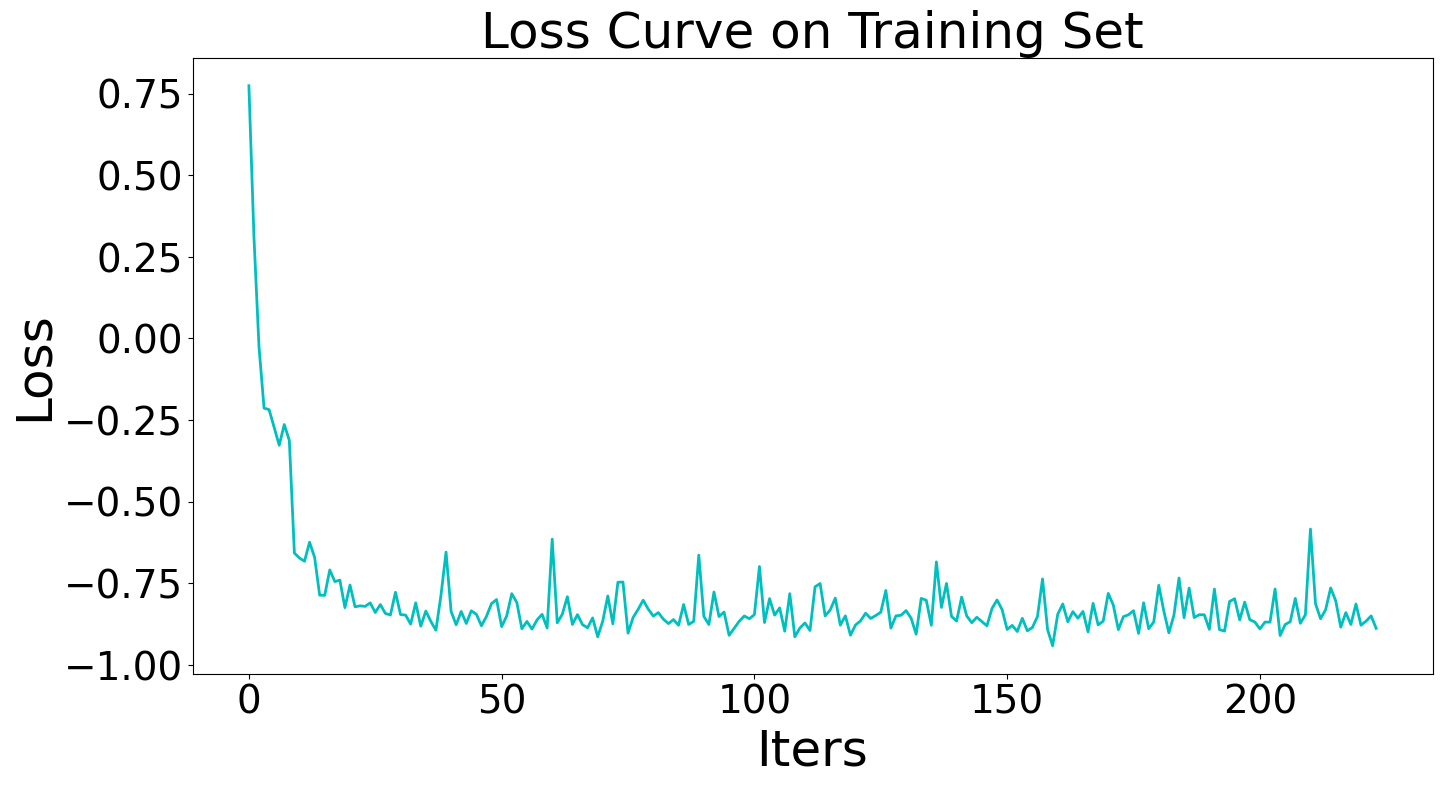

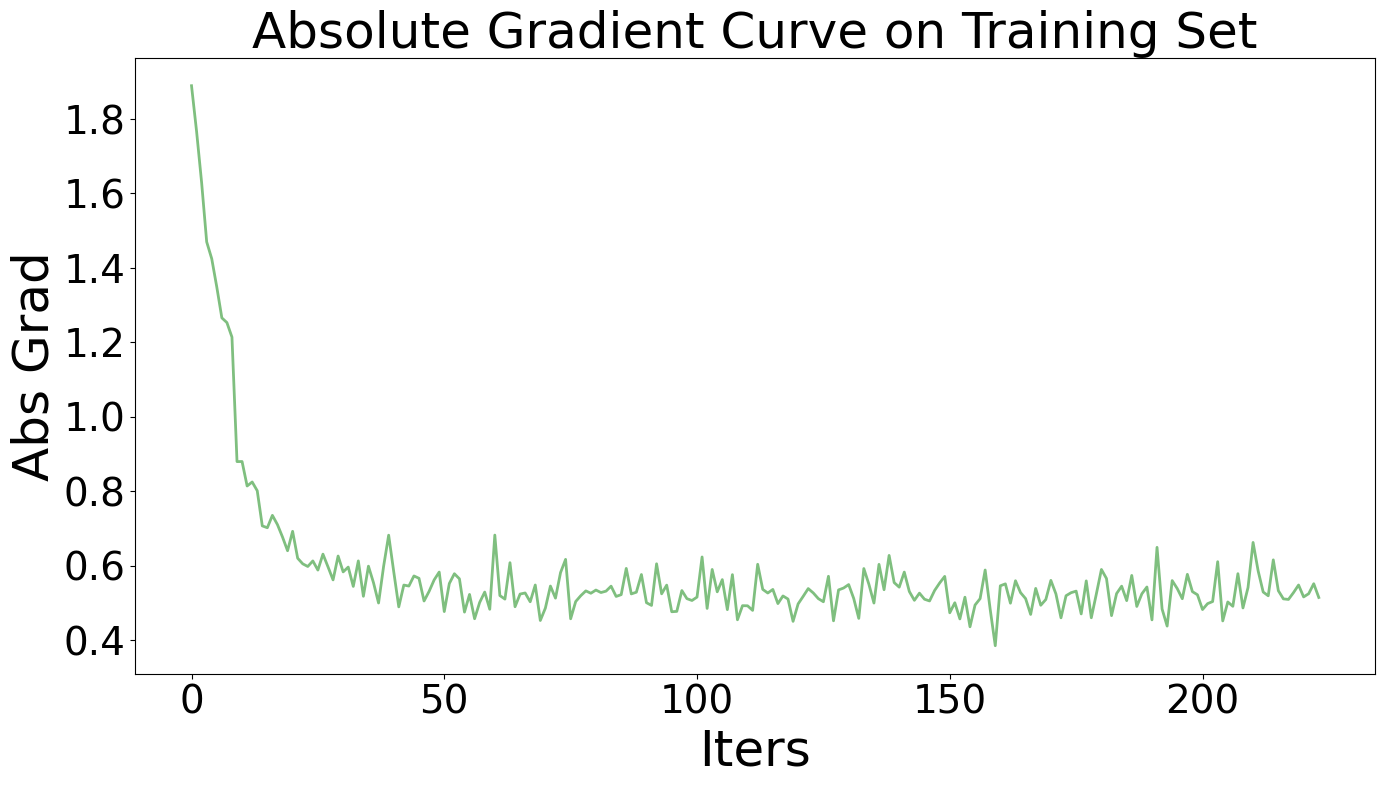

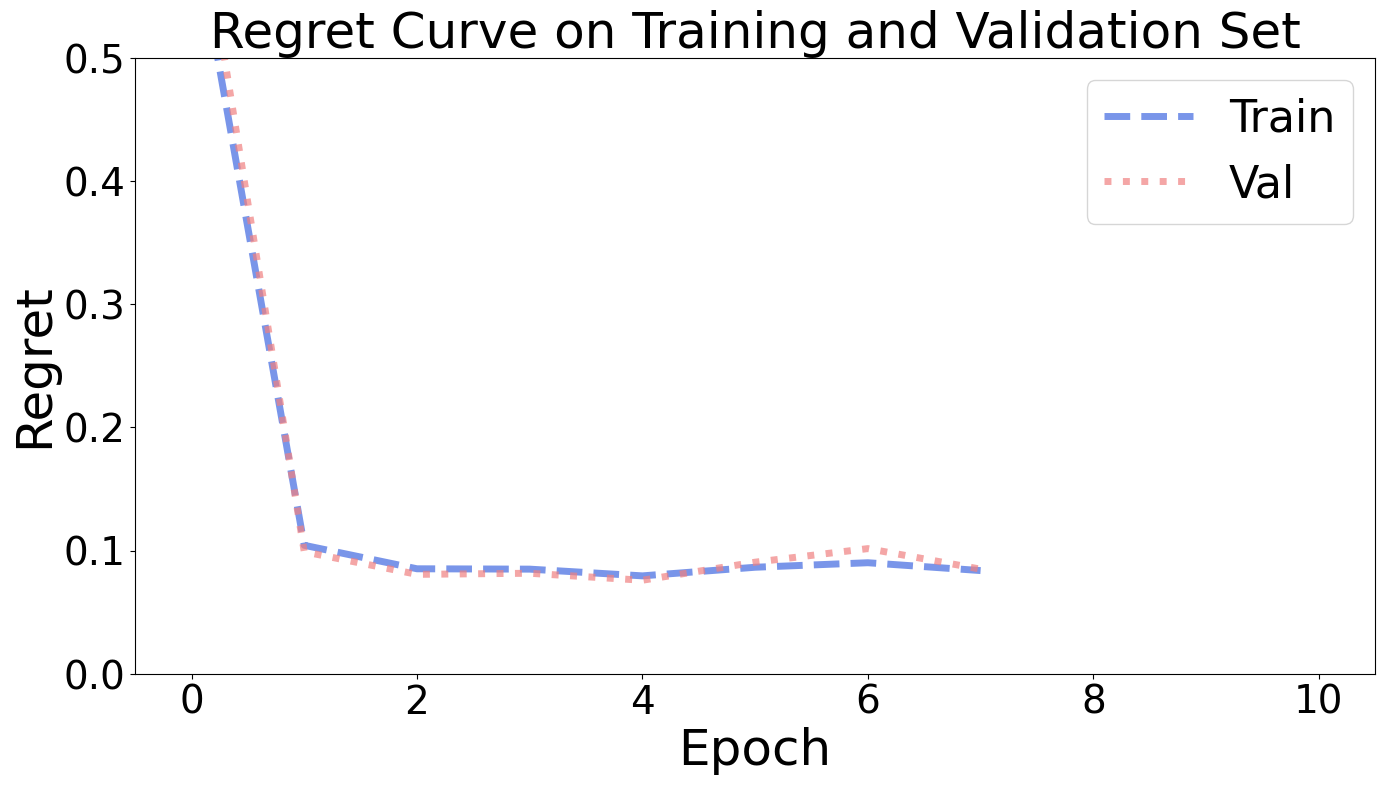

In [15]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Inner Method with NNLS 

In [16]:
# init model
reg = LinearRegression()

In [17]:
from func import innerConeAlignedCosine
# init loss
ca_cos = innerConeAlignedCosine(optmodel, solver="nnls", processes=1)

Num of cores: 1


In [18]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test, grad_clip=True)

  0%|                                                                                           | 0/10 [00:01<?, ?it/s]

Epoch   0, Train Regret:  54.3382%, Val Regret:  51.3118%


Epoch    0, Loss:  -0.4034:  10%|█████▌                                                 | 1/10 [00:04<00:26,  2.96s/it]

Epoch   1, Train Regret:  25.7732%, Val Regret:  24.5818%


Epoch    1, Loss:  -0.5893:  20%|███████████                                            | 2/10 [00:07<00:23,  2.97s/it]

Epoch   2, Train Regret:  14.3008%, Val Regret:  13.6537%


Epoch    2, Loss:  -0.8995:  30%|████████████████▌                                      | 3/10 [00:10<00:20,  2.93s/it]

Epoch   3, Train Regret:  10.4830%, Val Regret:   9.2029%


Epoch    3, Loss:  -0.8815:  40%|██████████████████████                                 | 4/10 [00:13<00:17,  2.94s/it]

Epoch   4, Train Regret:   8.6169%, Val Regret:   7.2769%


Epoch    4, Loss:  -0.9425:  50%|███████████████████████████▌                           | 5/10 [00:16<00:14,  2.93s/it]

Epoch   5, Train Regret:   7.9084%, Val Regret:   7.6698%


Epoch    5, Loss:  -0.8033:  60%|█████████████████████████████████                      | 6/10 [00:19<00:12,  3.00s/it]

Epoch   6, Train Regret:   7.5452%, Val Regret:   8.6685%


Epoch    6, Loss:  -0.8935:  70%|██████████████████████████████████████▌                | 7/10 [00:22<00:09,  3.24s/it]


Epoch   7, Train Regret:   7.7495%, Val Regret:   8.1937%

Early Stop!
Training Elapsed Time: 2.79 Sec

Evaluation:
Test Regret: 8.7556%
Test Elapsed Time: 1.53 Sec


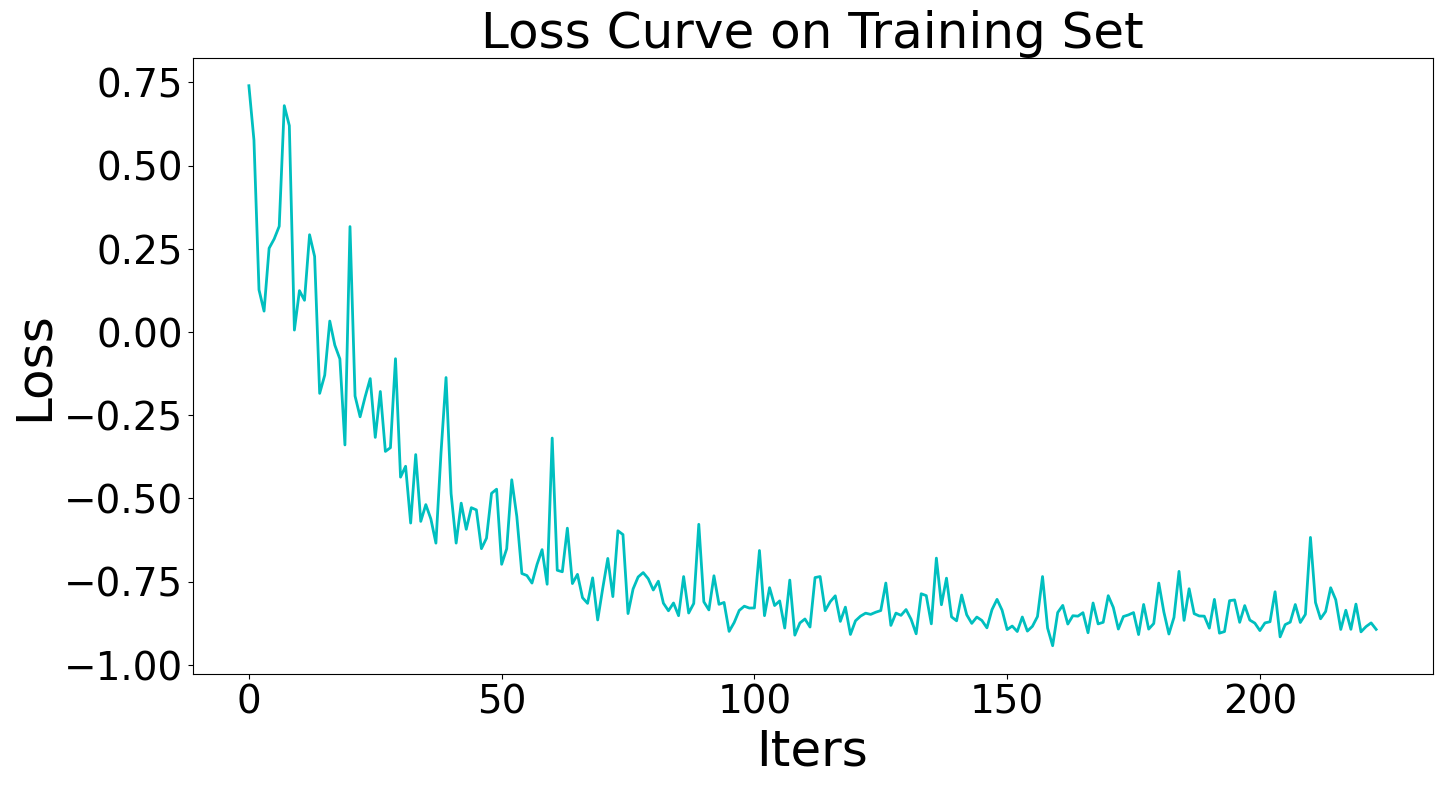

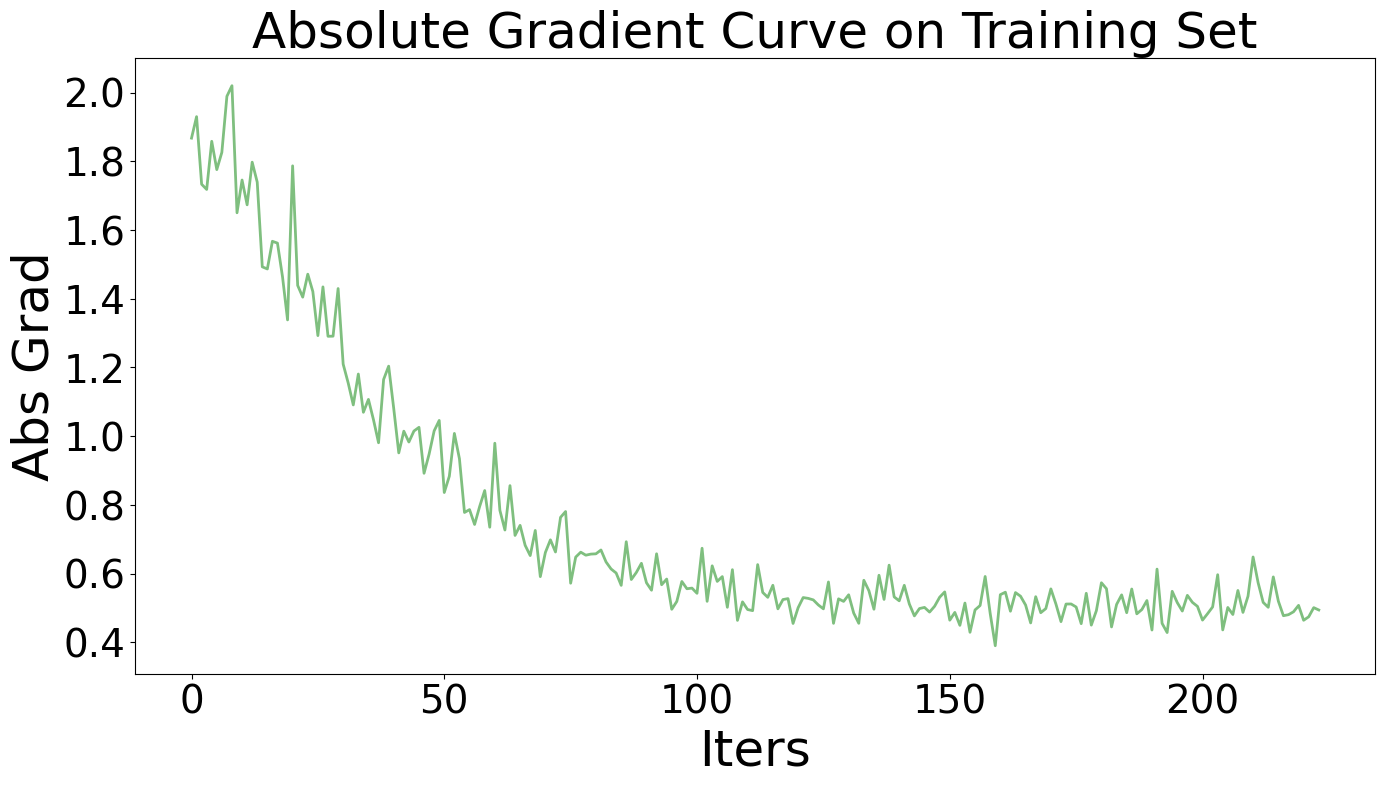

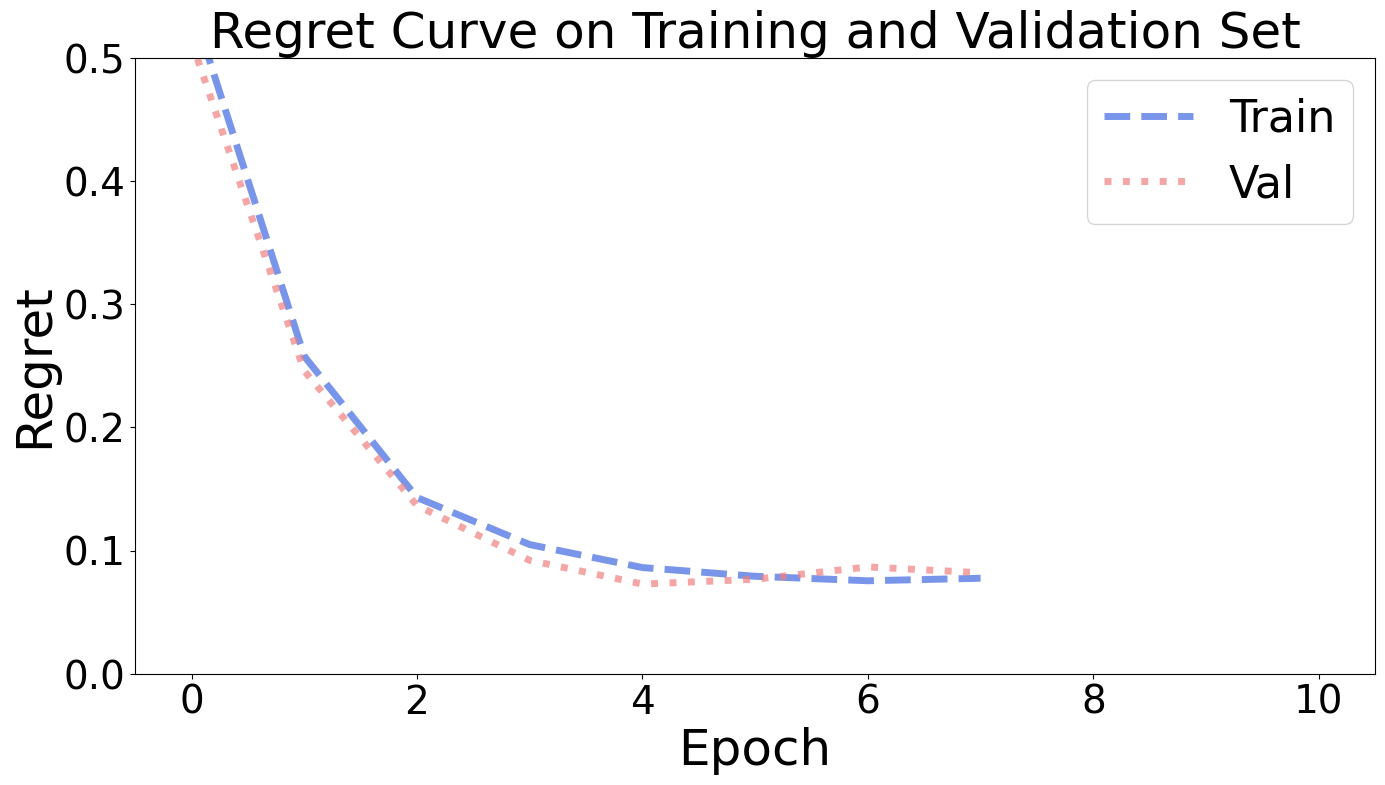

In [19]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Inner & Average Method

In [20]:
# init model
reg = LinearRegression()

In [21]:
from func import innerConeAlignedCosine
# init loss
ca_cos = innerConeAlignedCosine(optmodel, solver="nnls", solve_ratio=0.1, processes=1)

Num of cores: 1


In [22]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/10 [00:01<?, ?it/s]

Epoch   0, Train Regret:  54.3382%, Val Regret:  51.3118%


Epoch    0, Loss:  -0.4236:  10%|█████▌                                                 | 1/10 [00:04<00:25,  2.87s/it]

Epoch   1, Train Regret:  28.9460%, Val Regret:  26.8356%


Epoch    1, Loss:  -0.5900:  20%|███████████                                            | 2/10 [00:07<00:22,  2.80s/it]

Epoch   2, Train Regret:  15.7035%, Val Regret:  15.1216%


Epoch    2, Loss:  -0.8992:  30%|████████████████▌                                      | 3/10 [00:10<00:19,  2.83s/it]

Epoch   3, Train Regret:  10.5933%, Val Regret:   9.6936%


Epoch    3, Loss:  -0.8821:  40%|██████████████████████                                 | 4/10 [00:12<00:16,  2.78s/it]

Epoch   4, Train Regret:   8.6152%, Val Regret:   7.6989%


Epoch    4, Loss:  -0.9440:  50%|███████████████████████████▌                           | 5/10 [00:15<00:13,  2.75s/it]

Epoch   5, Train Regret:   7.9182%, Val Regret:   7.7169%


Epoch    5, Loss:  -0.8042:  60%|█████████████████████████████████                      | 6/10 [00:18<00:10,  2.74s/it]

Epoch   6, Train Regret:   7.5433%, Val Regret:   8.6047%


Epoch    6, Loss:  -0.8947:  70%|██████████████████████████████████████▌                | 7/10 [00:20<00:08,  2.97s/it]


Epoch   7, Train Regret:   7.7093%, Val Regret:   8.9169%

Early Stop!
Training Elapsed Time: 1.04 Sec

Evaluation:
Test Regret: 8.8776%
Test Elapsed Time: 1.41 Sec


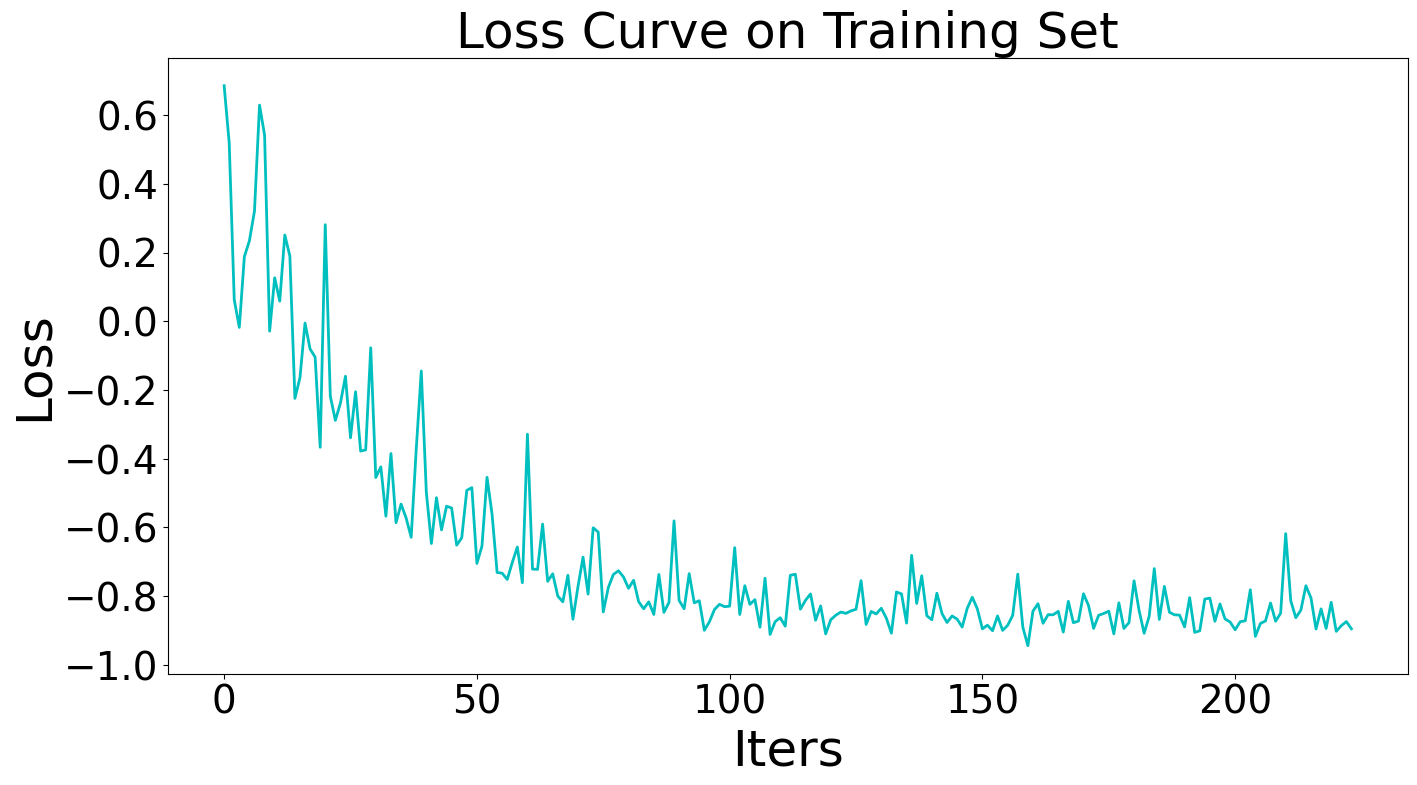

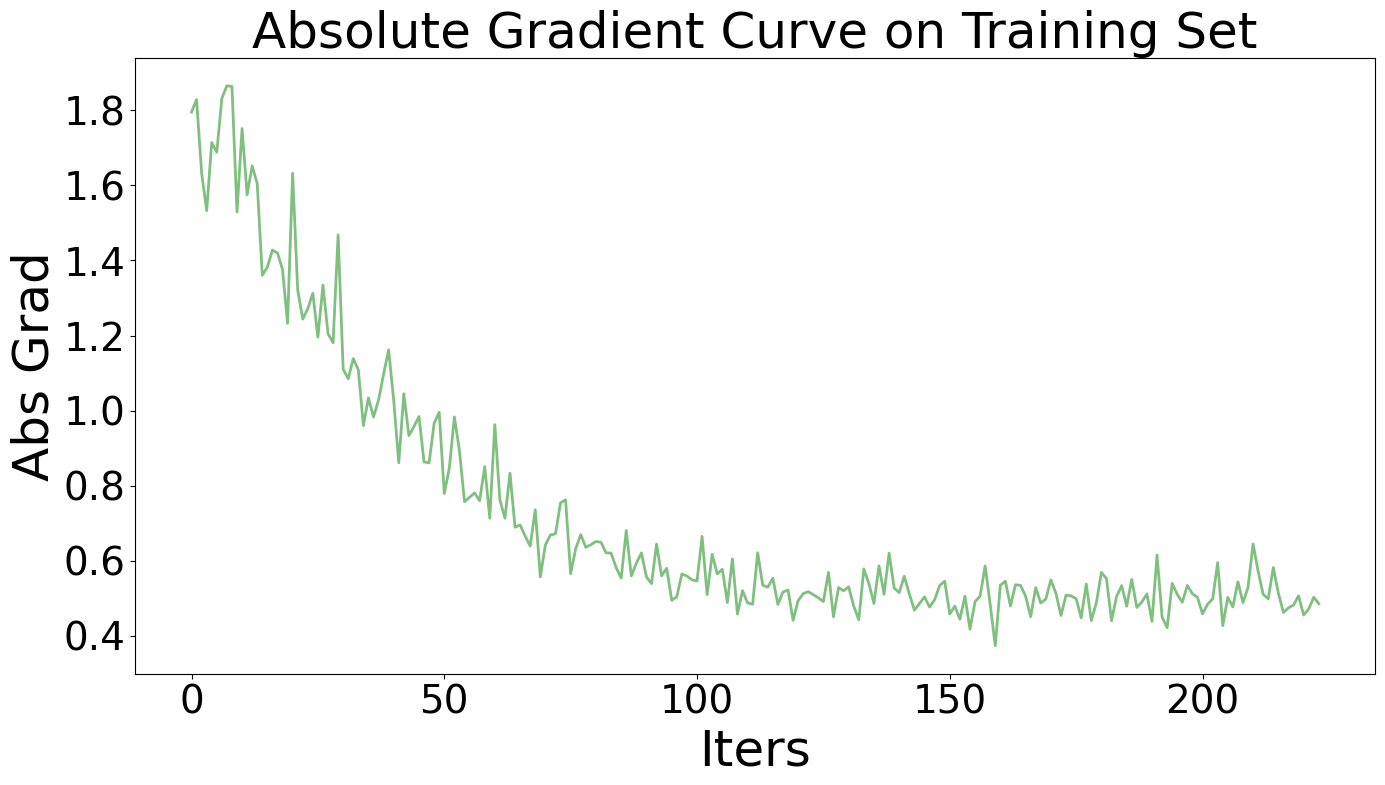

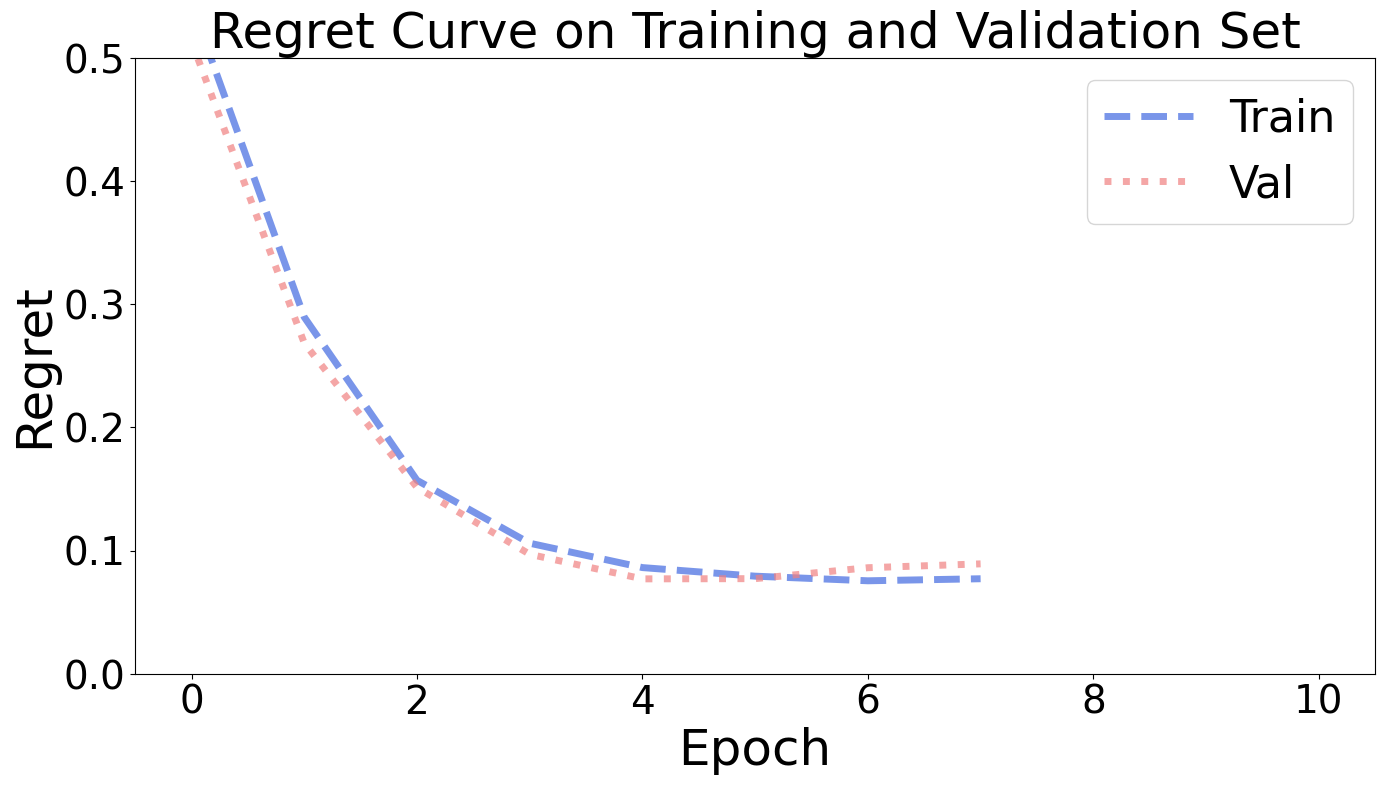

In [23]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method

In [24]:
# init model
reg = LinearRegression()

In [25]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100)

Num of cores: 1


In [26]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/10 [00:01<?, ?it/s]

Epoch   0, Train Regret:  54.3382%, Val Regret:  51.3118%


Epoch    0, Loss:  -0.8425:  10%|█████▌                                                 | 1/10 [00:04<00:26,  2.93s/it]

Epoch   1, Train Regret:   8.4748%, Val Regret:   8.8142%


Epoch    1, Loss:  -0.8667:  20%|███████████                                            | 2/10 [00:07<00:23,  2.96s/it]

Epoch   2, Train Regret:   8.5802%, Val Regret:  11.0995%


Epoch    2, Loss:  -0.8983:  30%|████████████████▌                                      | 3/10 [00:10<00:20,  2.89s/it]

Epoch   3, Train Regret:   8.4880%, Val Regret:   9.5191%


Epoch    3, Loss:  -0.8435:  40%|██████████████████████                                 | 4/10 [00:13<00:19,  3.33s/it]


Epoch   4, Train Regret:   9.5842%, Val Regret:  10.6040%

Early Stop!
Training Elapsed Time: 0.89 Sec

Evaluation:
Test Regret: 8.8598%
Test Elapsed Time: 1.48 Sec


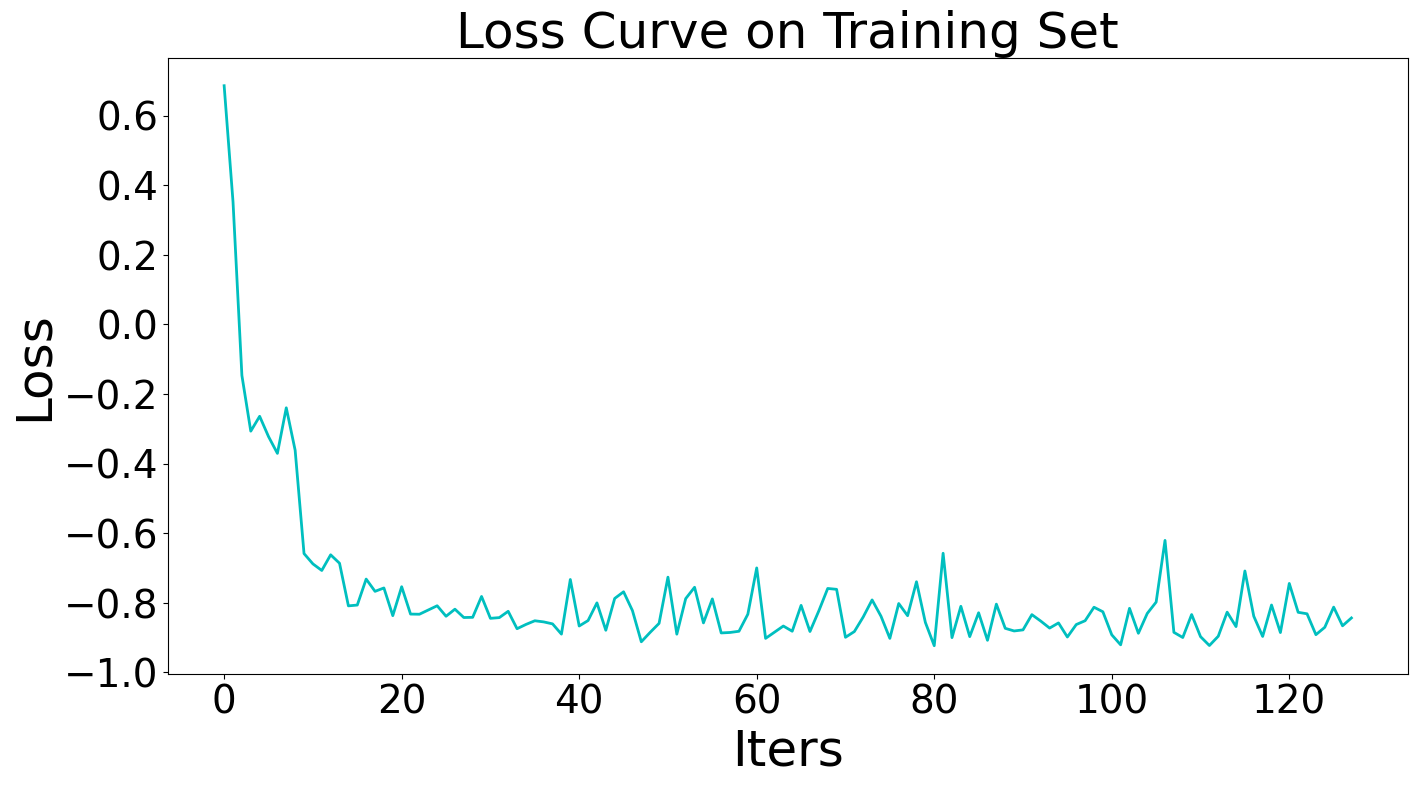

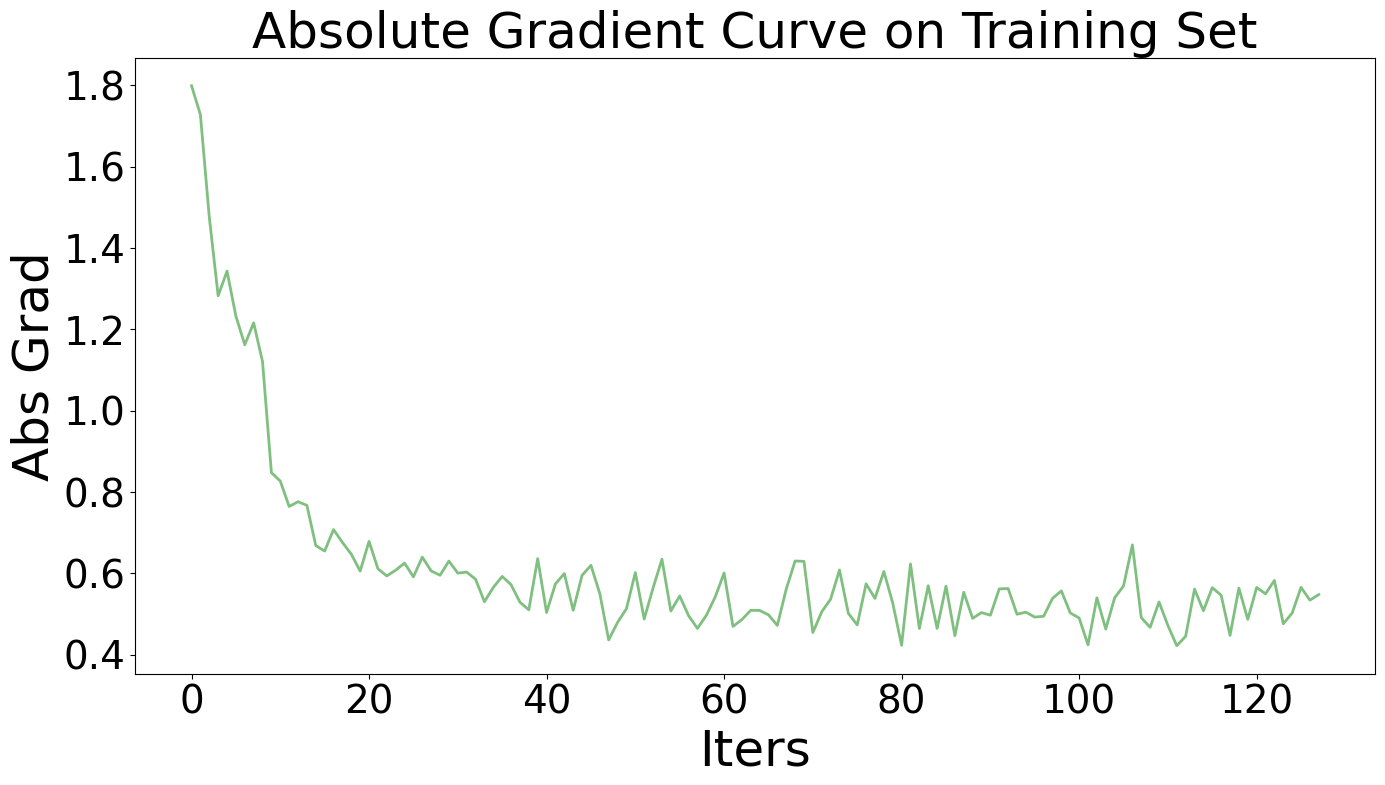

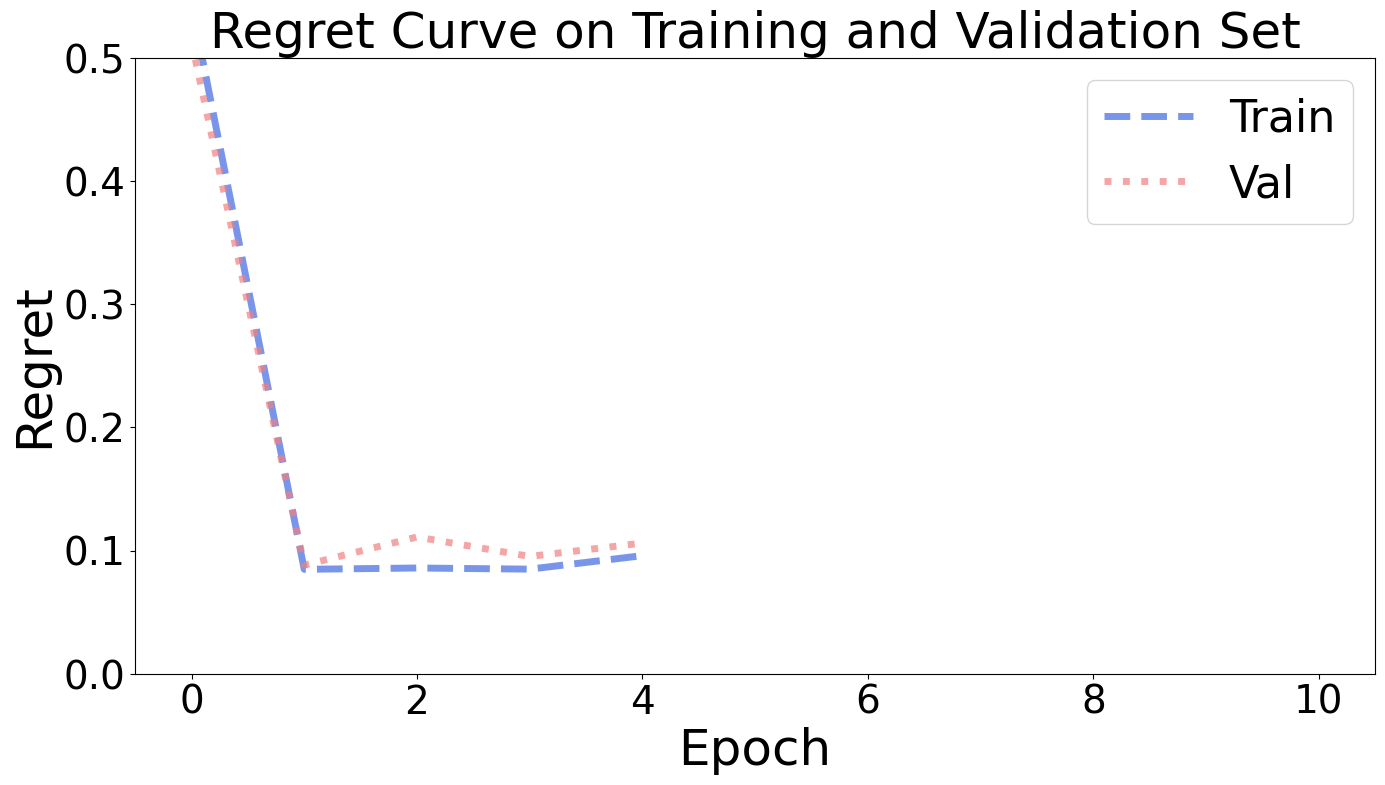

In [27]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method with Cone Check 

In [28]:
# init model
reg = LinearRegression()

In [29]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100, check_cone=True)

Num of cores: 1


In [30]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/10 [00:01<?, ?it/s]

Epoch   0, Train Regret:  53.4340%, Val Regret:  54.0335%


Epoch    0, Loss:  -0.8485:  10%|█████▌                                                 | 1/10 [00:06<00:42,  4.68s/it]

Epoch   1, Train Regret:   9.6400%, Val Regret:   9.4578%


Epoch    1, Loss:  -0.8674:  20%|███████████                                            | 2/10 [00:11<00:37,  4.67s/it]

Epoch   2, Train Regret:   8.2170%, Val Regret:  10.6329%


Epoch    2, Loss:  -0.8997:  30%|████████████████▌                                      | 3/10 [00:15<00:32,  4.64s/it]

Epoch   3, Train Regret:   8.5131%, Val Regret:   8.6658%


Epoch    3, Loss:  -0.8425:  40%|██████████████████████                                 | 4/10 [00:20<00:27,  4.62s/it]

Epoch   4, Train Regret:   9.3270%, Val Regret:  10.0229%


Epoch    4, Loss:  -0.8831:  50%|███████████████████████████▌                           | 5/10 [00:24<00:23,  4.63s/it]

Epoch   5, Train Regret:   8.5485%, Val Regret:   7.9614%


Epoch    5, Loss:  -0.8655:  60%|█████████████████████████████████                      | 6/10 [00:29<00:18,  4.66s/it]

Epoch   6, Train Regret:   8.7053%, Val Regret:   9.1714%


Epoch    6, Loss:  -0.7703:  70%|██████████████████████████████████████▌                | 7/10 [00:34<00:14,  4.75s/it]

Epoch   7, Train Regret:   8.9183%, Val Regret:   8.1552%


Epoch    7, Loss:  -0.8891:  80%|████████████████████████████████████████████           | 8/10 [00:39<00:09,  4.75s/it]

Epoch   8, Train Regret:   8.1695%, Val Regret:   7.5307%


Epoch    8, Loss:  -0.8963:  90%|█████████████████████████████████████████████████▌     | 9/10 [00:44<00:04,  4.77s/it]

Epoch   9, Train Regret:   8.9190%, Val Regret:  11.1538%


Epoch    9, Loss:  -0.8723: 100%|██████████████████████████████████████████████████████| 10/10 [00:47<00:00,  4.73s/it]


Epoch   9, Train Regret:   8.9911%, Val Regret:  10.5937%
Training Elapsed Time: 19.87 Sec

Evaluation:
Test Regret: 8.9376%
Test Elapsed Time: 1.63 Sec


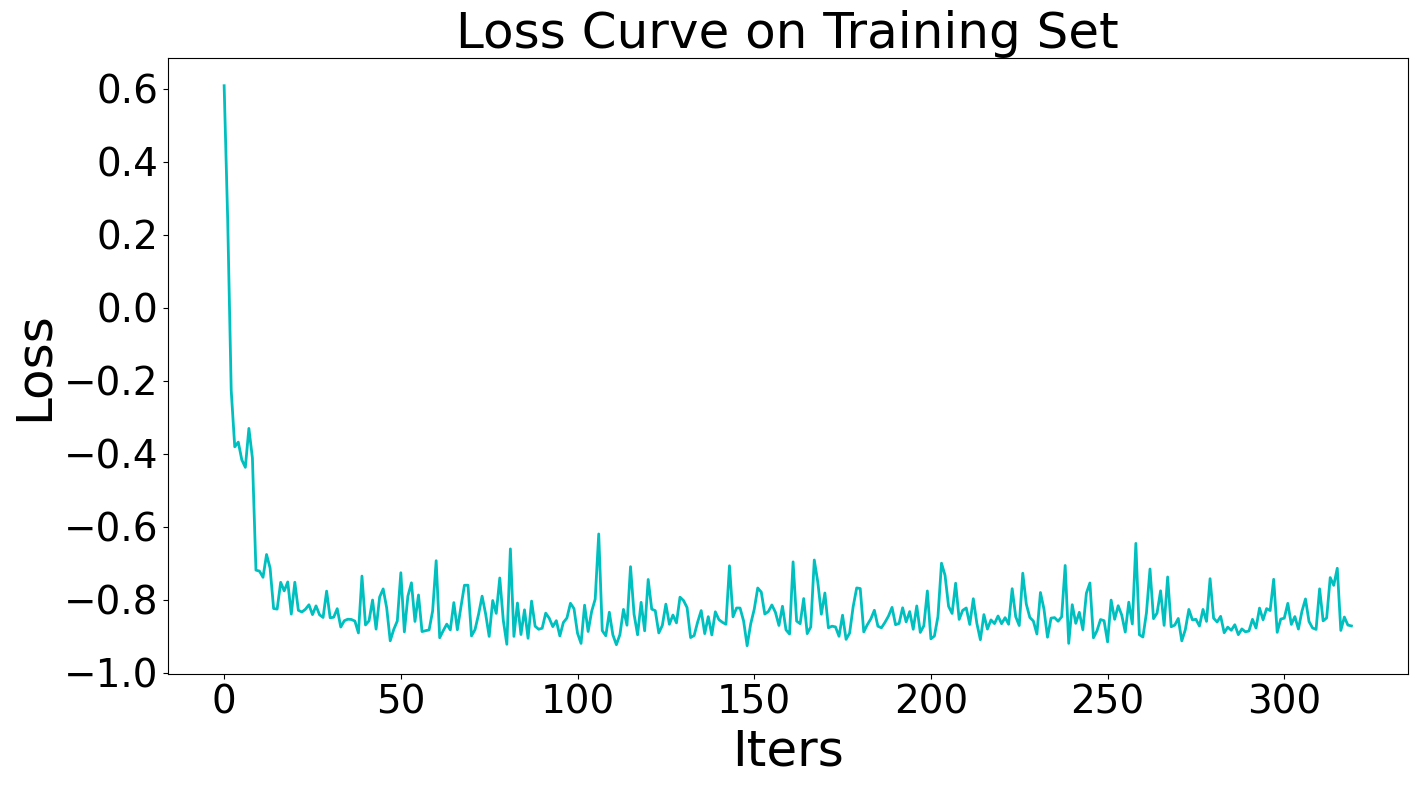

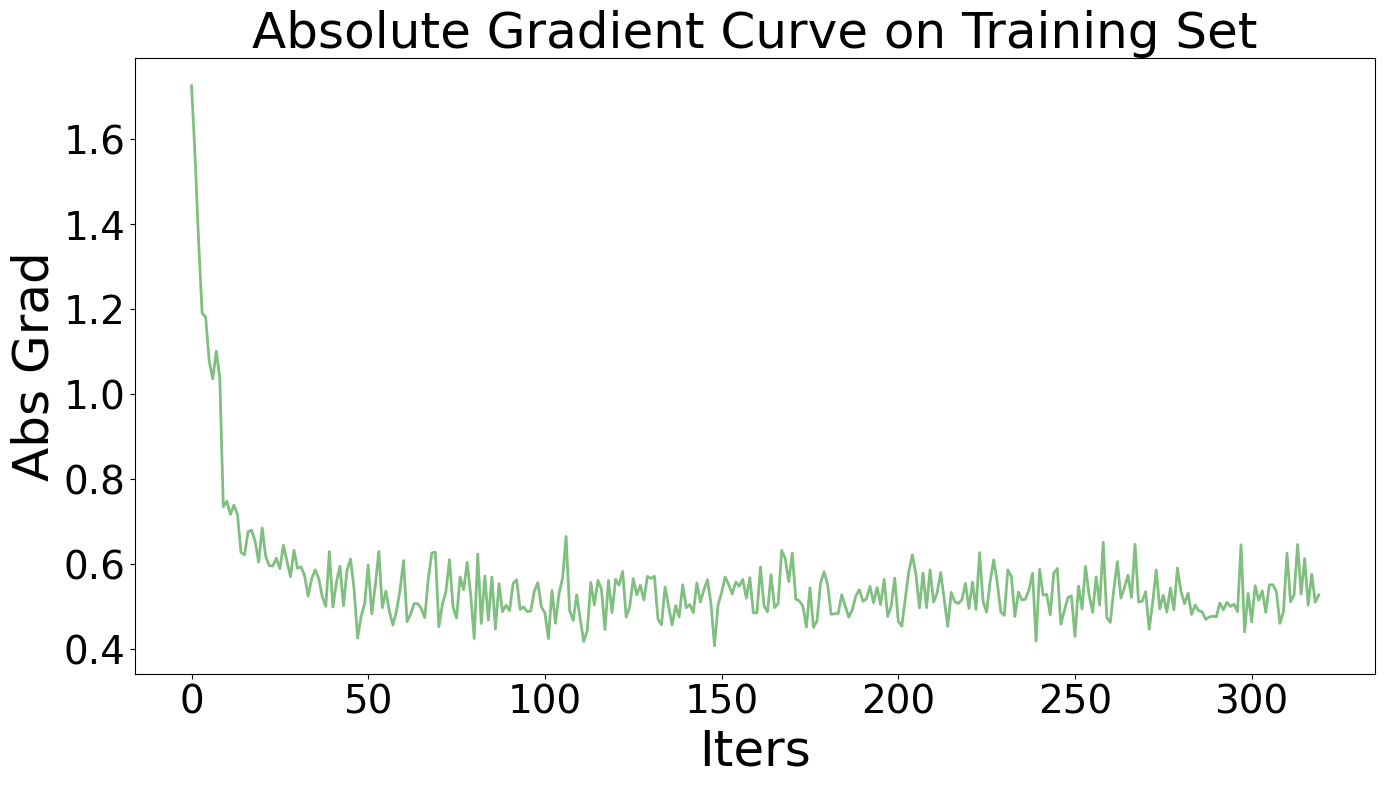

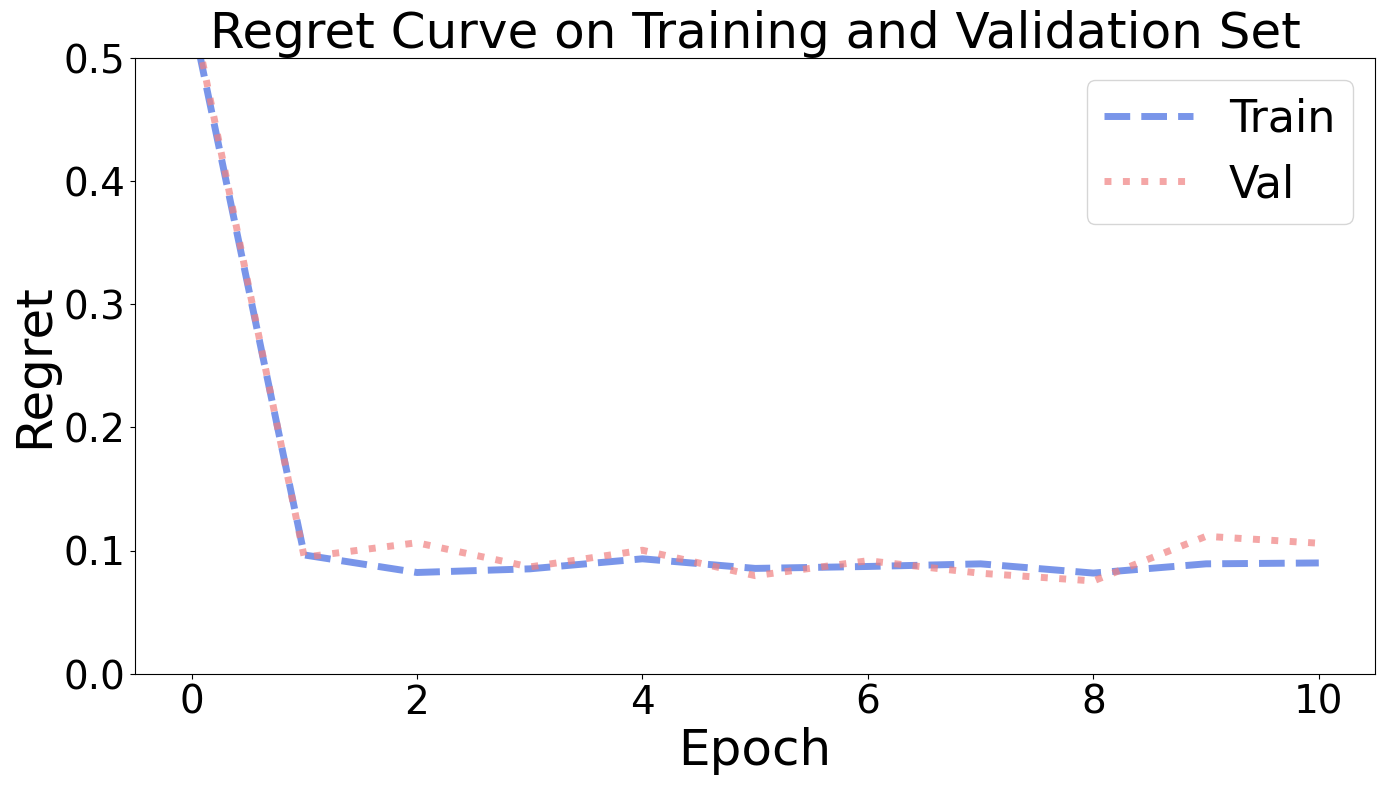

In [31]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Average Method 

In [32]:
# init model
reg = LinearRegression()

In [33]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel)

Num of cores: 1


In [34]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/10 [00:01<?, ?it/s]

Epoch   0, Train Regret:  64.9930%, Val Regret:  68.2556%


Epoch    0, Loss:  -0.8535:  10%|█████▌                                                 | 1/10 [00:04<00:26,  2.90s/it]

Epoch   1, Train Regret:   9.6550%, Val Regret:  10.1153%


Epoch    1, Loss:  -0.7900:  20%|███████████                                            | 2/10 [00:07<00:23,  2.89s/it]

Epoch   2, Train Regret:   8.6541%, Val Regret:  10.0626%


Epoch    2, Loss:  -0.9106:  30%|████████████████▌                                      | 3/10 [00:10<00:20,  2.91s/it]

Epoch   3, Train Regret:   8.2728%, Val Regret:  10.0289%


Epoch    3, Loss:  -0.8877:  40%|██████████████████████                                 | 4/10 [00:13<00:17,  2.90s/it]

Epoch   4, Train Regret:   8.1835%, Val Regret:   7.7416%


Epoch    4, Loss:  -0.9417:  50%|███████████████████████████▌                           | 5/10 [00:16<00:14,  2.93s/it]

Epoch   5, Train Regret:   8.7761%, Val Regret:   8.0609%


Epoch    5, Loss:  -0.7676:  60%|█████████████████████████████████                      | 6/10 [00:19<00:11,  2.89s/it]

Epoch   6, Train Regret:   8.7522%, Val Regret:  10.9156%


Epoch    6, Loss:  -0.8905:  70%|██████████████████████████████████████▌                | 7/10 [00:21<00:09,  3.12s/it]


Epoch   7, Train Regret:   8.4404%, Val Regret:   8.8295%

Early Stop!
Training Elapsed Time: 0.88 Sec

Evaluation:
Test Regret: 8.4213%
Test Elapsed Time: 1.54 Sec


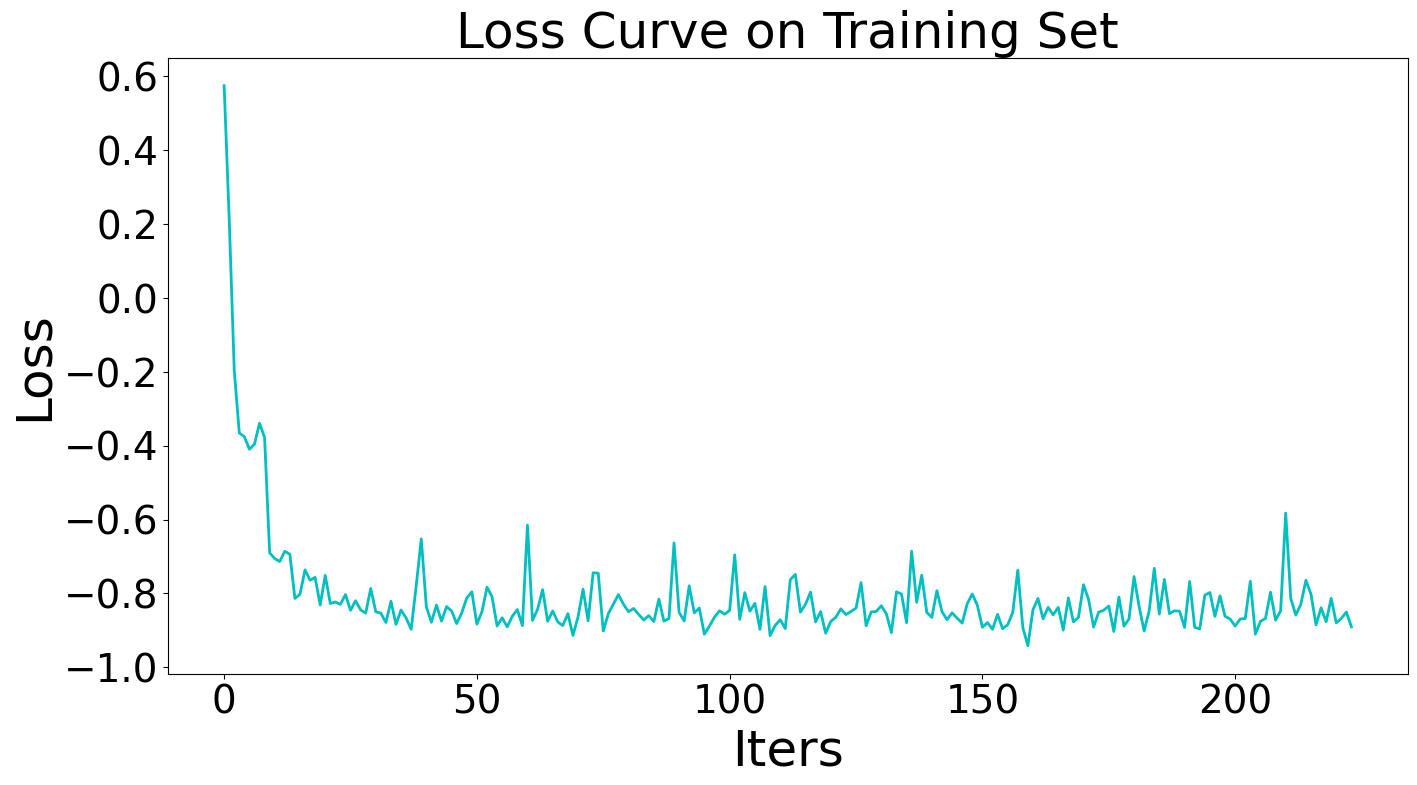

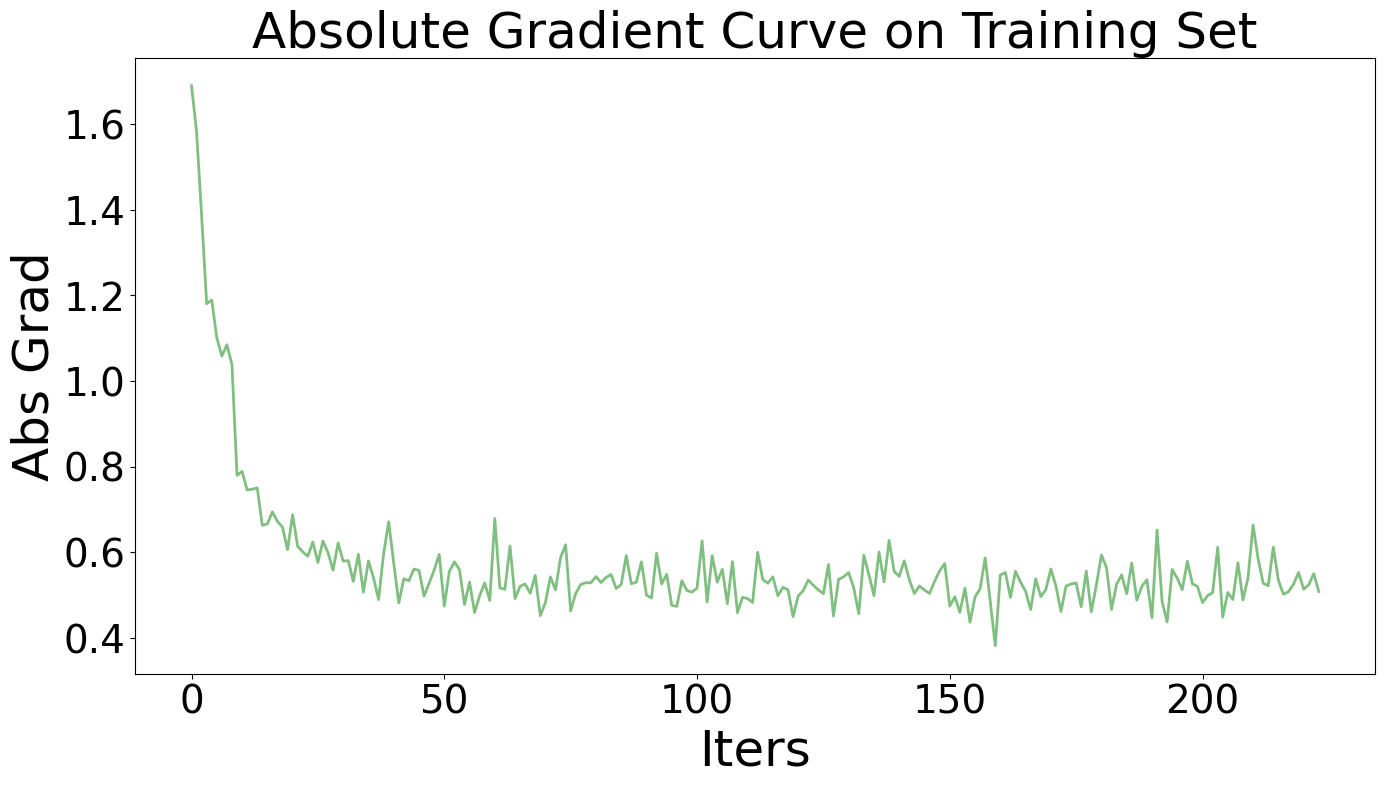

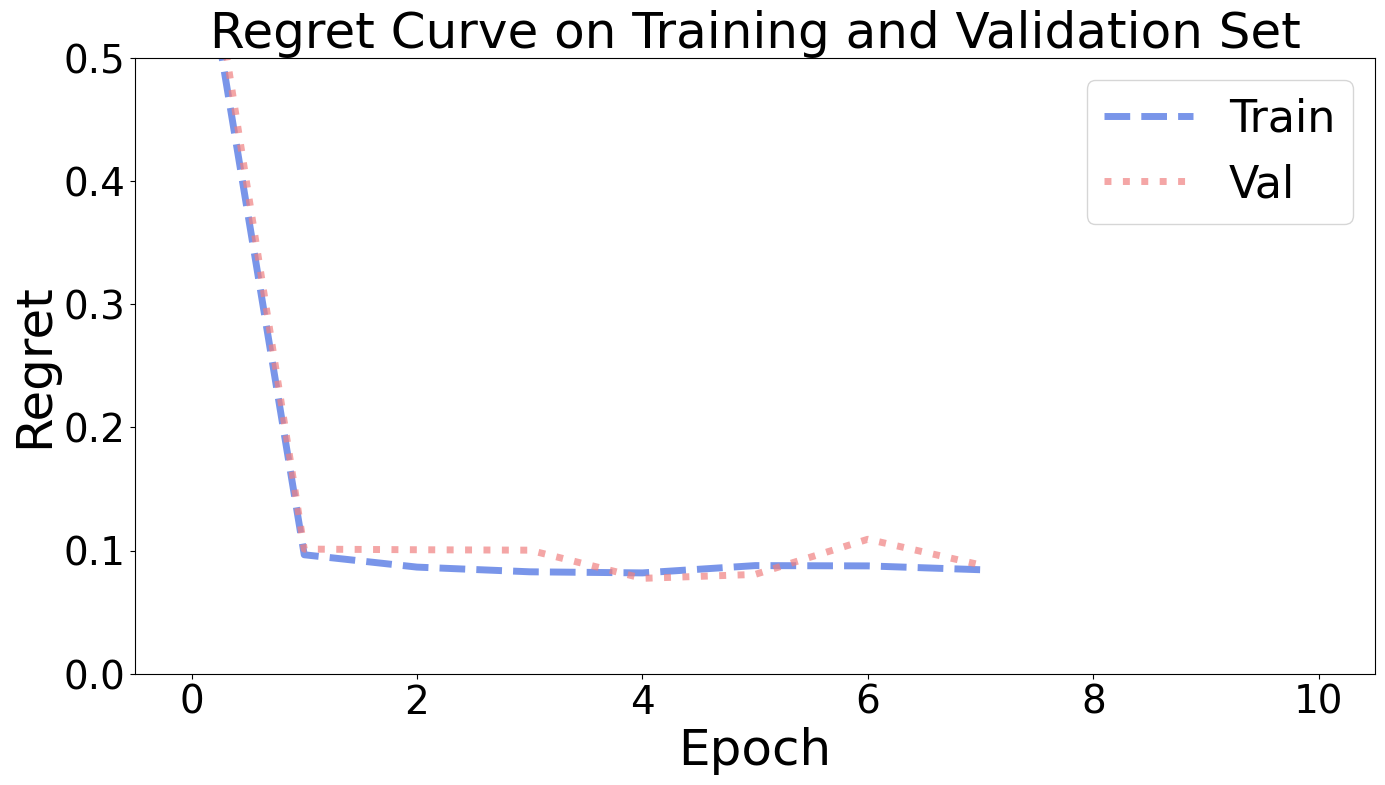

In [35]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Average Method with Cone Check 

In [36]:
# init model
reg = LinearRegression()

In [37]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel, check_cone=True)

Num of cores: 1


In [38]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/10 [00:01<?, ?it/s]

Epoch   0, Train Regret:  54.3382%, Val Regret:  51.3118%


Epoch    0, Loss:  -0.8431:  10%|█████▌                                                 | 1/10 [00:06<00:39,  4.42s/it]

Epoch   1, Train Regret:   8.4813%, Val Regret:   8.8517%


Epoch    1, Loss:  -0.7881:  20%|███████████                                            | 2/10 [00:10<00:36,  4.50s/it]

Epoch   2, Train Regret:   8.4436%, Val Regret:   9.0551%


Epoch    2, Loss:  -0.9090:  30%|████████████████▌                                      | 3/10 [00:15<00:31,  4.51s/it]

Epoch   3, Train Regret:   8.3375%, Val Regret:   9.5326%


Epoch    3, Loss:  -0.8863:  40%|██████████████████████                                 | 4/10 [00:19<00:27,  4.51s/it]

Epoch   4, Train Regret:   8.2273%, Val Regret:   8.2868%


Epoch    4, Loss:  -0.9414:  50%|███████████████████████████▌                           | 5/10 [00:24<00:22,  4.51s/it]

Epoch   5, Train Regret:   8.8031%, Val Regret:   7.9959%


Epoch    5, Loss:  -0.7707:  60%|█████████████████████████████████                      | 6/10 [00:28<00:17,  4.49s/it]

Epoch   6, Train Regret:   8.5664%, Val Regret:  10.6666%


Epoch    6, Loss:  -0.8894:  70%|██████████████████████████████████████▌                | 7/10 [00:33<00:13,  4.51s/it]

Epoch   7, Train Regret:   8.8779%, Val Regret:   8.3369%


Epoch    7, Loss:  -0.9302:  80%|████████████████████████████████████████████           | 8/10 [00:37<00:09,  4.71s/it]


Epoch   8, Train Regret:   8.6072%, Val Regret:   8.0016%

Early Stop!
Training Elapsed Time: 14.41 Sec

Evaluation:
Test Regret: 8.8046%
Test Elapsed Time: 1.53 Sec


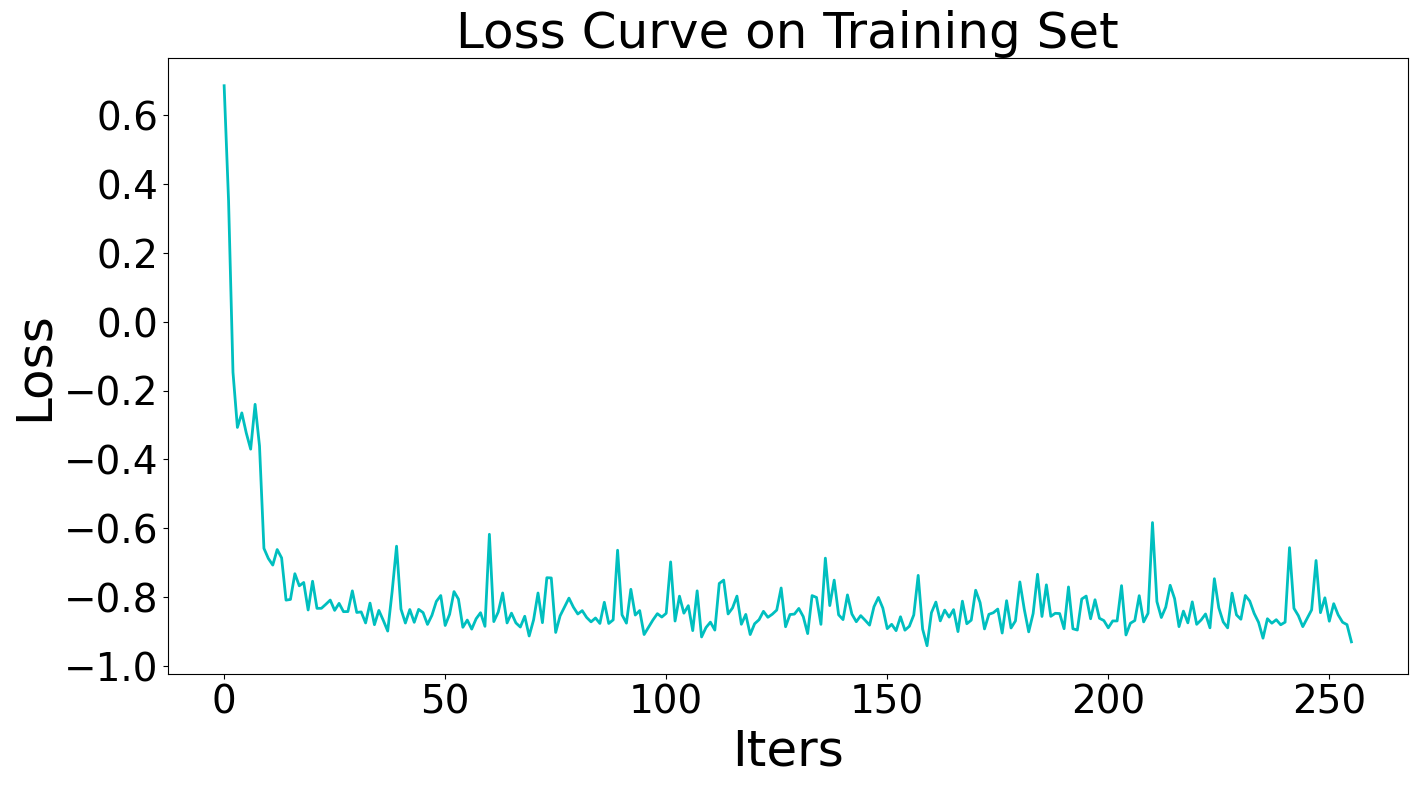

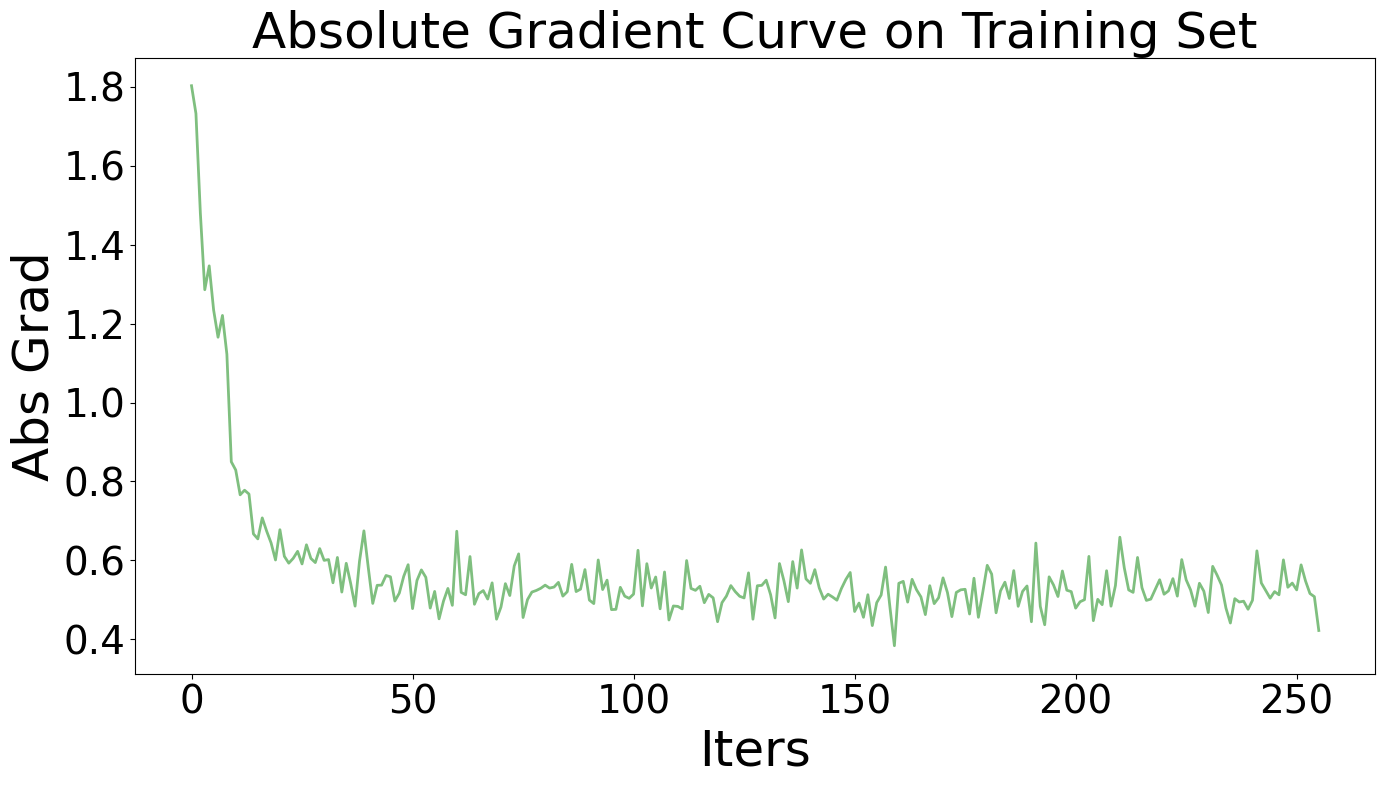

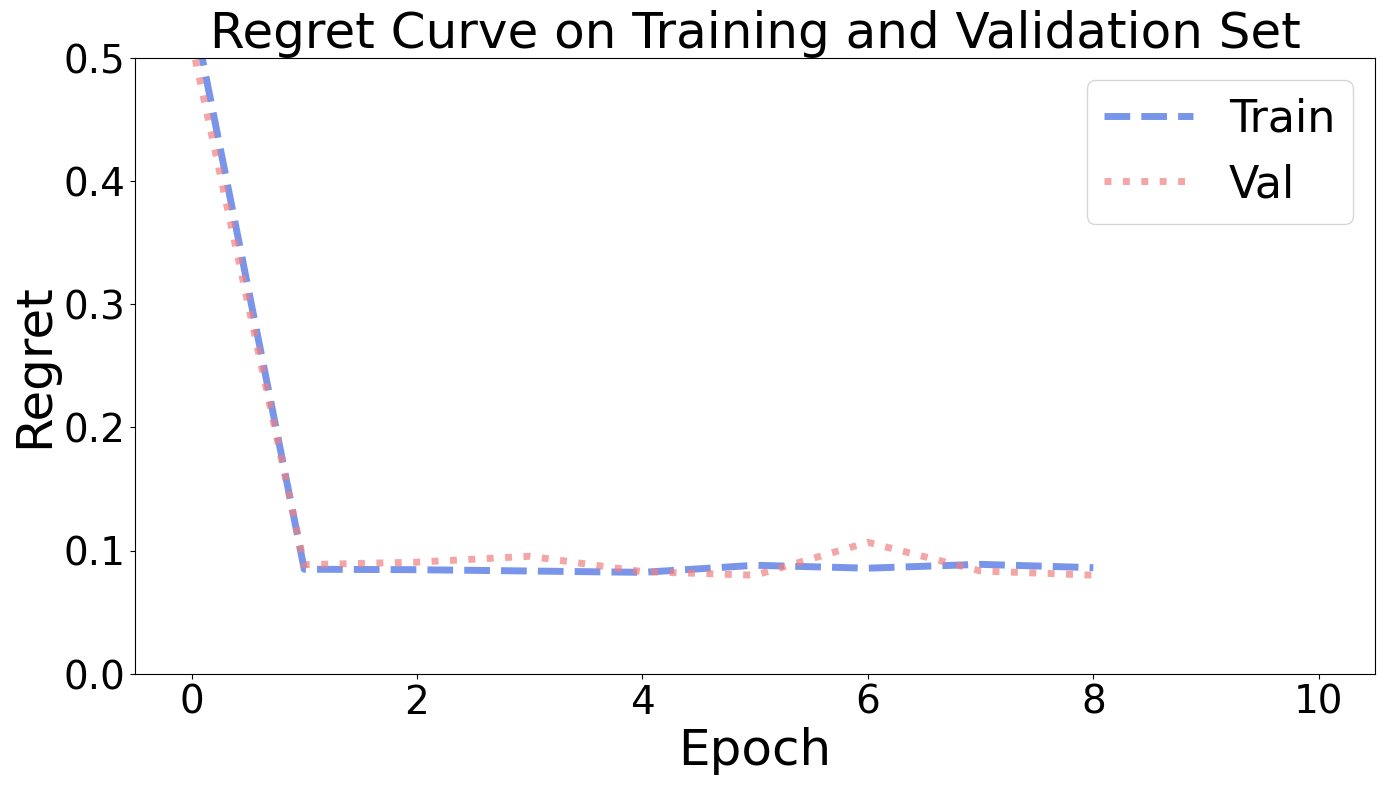

In [39]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)